## Notebook to determine ROIs for overlapping cells in 3d spot-based transcriptomics data

In [5]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Basic imports:

In [6]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata


#### Define parameters

In [7]:
# SSAM vector field resolution:
um_per_pixel = 2.5

# SSAM pandwidth:
bw = 1

# KNN diffusion iterations to move spots to z-axis zero mean:
z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


## Define & load data

####  0: Xenium Mouse brain dataset:

In [8]:

if dataset == 0:

    # adata = anndata.read_h5ad(os.path.join(file_root,'../../data/z-incoherence/counts_WS_blur5_exp0.h5ad'))

    # coords_louis = adata.uns['spots'].copy()

    adata = anndata.read_h5ad(os.path.join(file_root,
                '../../../../raw_data/Xenium-benchmark/spatial//ms_brain_multisection1.h5ad'),)

    coords = adata.uns['spots'].copy()
    coords = coords[~(coords.feature_name.str.contains("BLANK") | coords.feature_name.str.contains("NegControl"))]

    spot_df_raw = coords[['x_location' ,'y_location' ,'z_location','feature_name' ]]#,'cell_id','cell_type_louis','cell_id_louis']]

    # replace the feature_name Ccn2 with Ctgf, which is present in the scRNAseq data:
    # spot_df_raw.loc[spot_df_raw.feature_name=='Ccn2','feature_name'] = 'Ctgf'
    spot_df_raw.columns = ['x','y','z','gene' ,]#'cell_id','cell_type_louis','cell_id_louis']
    spot_df_raw = spot_df_raw[~spot_df_raw.gene.str.contains('Blank')][::1]
    spot_df_raw['gene']=spot_df_raw['gene'].astype('category')

    # spot_df = spot_df_raw.copy()
    genes = sorted(spot_df_raw.gene.unique())


del coords,
spot_df_raw


,x,y,z,gene
transcript_id,,,,
281474976710664,4843.0460,6427.7300,19.068869,Bhlhe40
281474976710665,4844.6330,6223.1826,18.520160,Parm1
281474976710667,4842.9434,6478.3105,18.500109,Bhlhe40
281474976710669,4843.9414,6344.5503,15.016154,Lyz2
281474976710670,4843.1626,6632.1120,15.394680,Dkk3
...,...,...,...,...
281977488696810,3656.9348,5991.1730,14.609873,Zfp536
281977488696812,3656.0498,5359.0933,17.772276,Parm1
281977488696814,3656.7720,5429.7690,15.828760,Meis2


In [9]:
spot_df_raw.to_csv(os.path.join('spot_df_raw.csv'))

In [10]:
spot_df_raw.x-=spot_df_raw.x.min()
spot_df_raw.y-=spot_df_raw.y.min()

spot_df_raw.x/=um_per_pixel
spot_df_raw.y/=um_per_pixel

In [18]:
from src import ovrlp

# roi_df = ovrlp.find_overlaps(spot_df_raw,threshold_fraction=0.4,density_weight=0.3,min_distance=20,return_maps=True)
rois_x, rois_y, divergence, signal, divergence_map = ovrlp.compute_divergence(spot_df_raw, genes, plot=False,
                                            threshold_fraction=0.4,density_weight=0.3,
                                            min_distanc e=20,return_maps=True)

# _=ovrlp.assign_xy(spot_df_raw)
roi_df = pd.DataFrame({'x':rois_x, 'y':rois_y, 'divergence':divergence})

,x,y,divergence
3582,2125,322,15.136188
1283,798,2204,11.646329
1879,1154,456,11.501783
3561,2111,322,11.490471
2547,1566,343,11.290755
...,...,...,...
2691,1639,2498,6.054716
4685,2748,550,6.054674
6311,3572,2087,6.054663
88,219,1051,6.054575


Text(0.5, 1.0, 'incoherence')

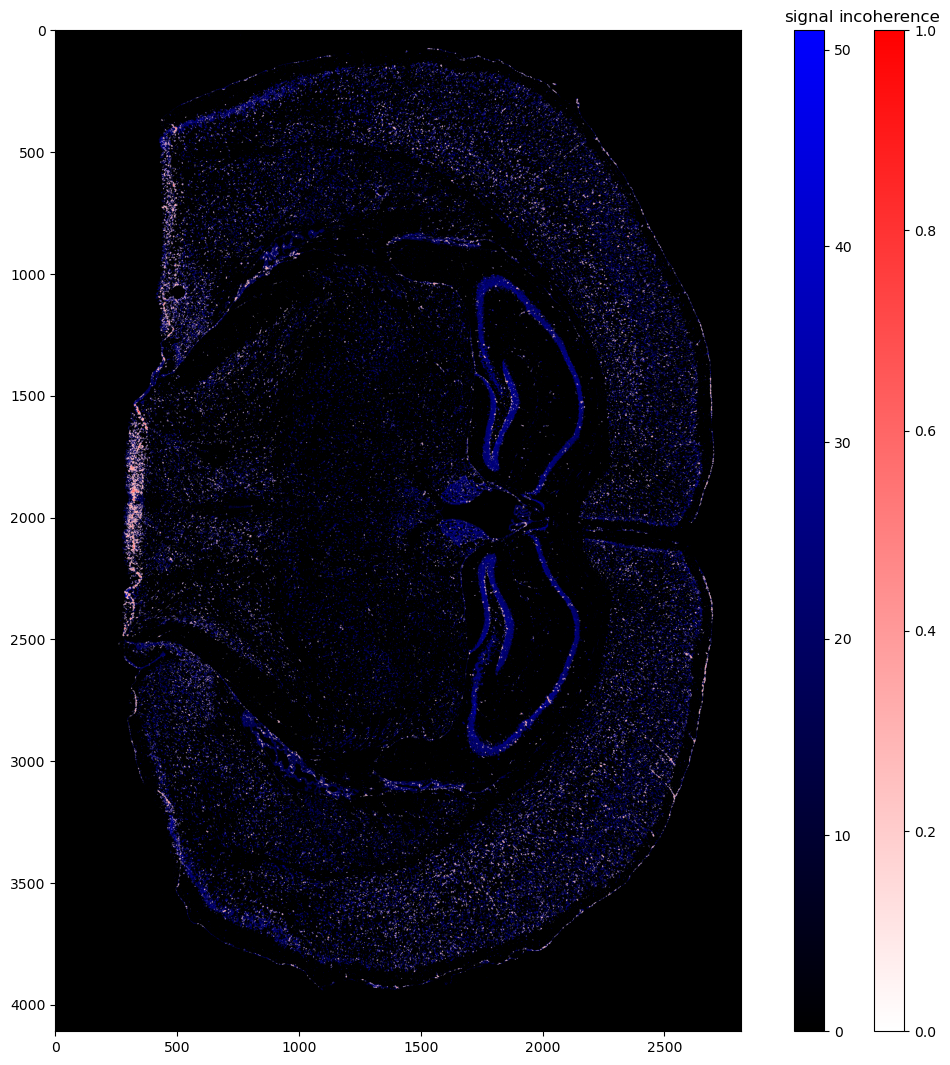

In [37]:
from matplotlib.colors import LinearSegmentedColormap


# rois_x, rois_y, divergence, signal, divergence_map = ovrlp.compute_divergence(spot_df_raw, genes, plot=False,
#                                             threshold_fraction=0.4,density_weight=0.3,
#                                             min_distance=20,return_maps=True)

BlGr = LinearSegmentedColormap.from_list('BlGr', ['black','blue'], N=256)
TrRd = LinearSegmentedColormap.from_list('TrRd', [[1.0,1.0,1.0,1.0],[1.0,0.0,0.0,1.0]], N=256)

f, (p, b1,b2) = plt.subplots(1, 3, width_ratios=[23, 1,1],figsize=(11,13))

handle_hist_sum_alpha = (hist_sum>(np.max(hist_sum)/5)).astype(float)
handle_hist_sum = p.imshow(hist_sum,cmap=BlGr,alpha=handle_hist_sum_alpha)
p.set_facecolor('black')

incoherence = divergence_map*hist_sum
incoherence/=incoherence.max()
incoherence_alpha = (incoherence>(np.max(incoherence)/5)).astype(float)
handle_divergence = p.imshow(incoherence,cmap=TrRd,alpha=incoherence_alpha)

plt.colorbar(handle_hist_sum,cax=b1)
plt.colorbar(handle_divergence,cax=b2)

b1.set_title('signal')
b2.set_title('incoherence')


In [61]:
vis = ovrlp.Visualizer()

vis.fit(spot_df_raw,signature_matrix=signatures)

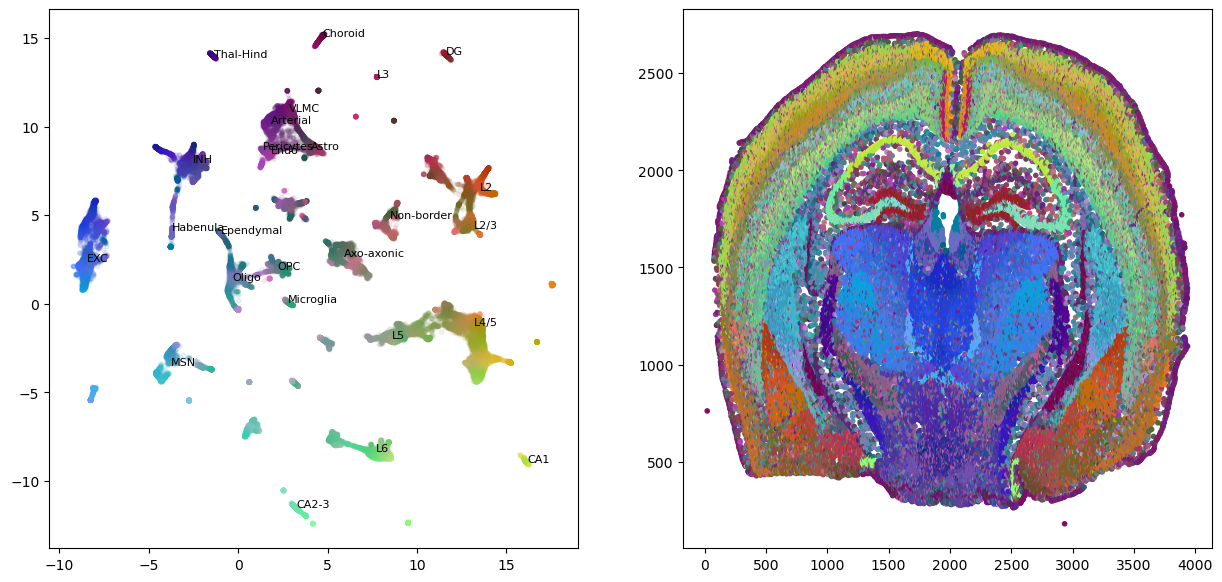

In [62]:
vis.plot_fit()

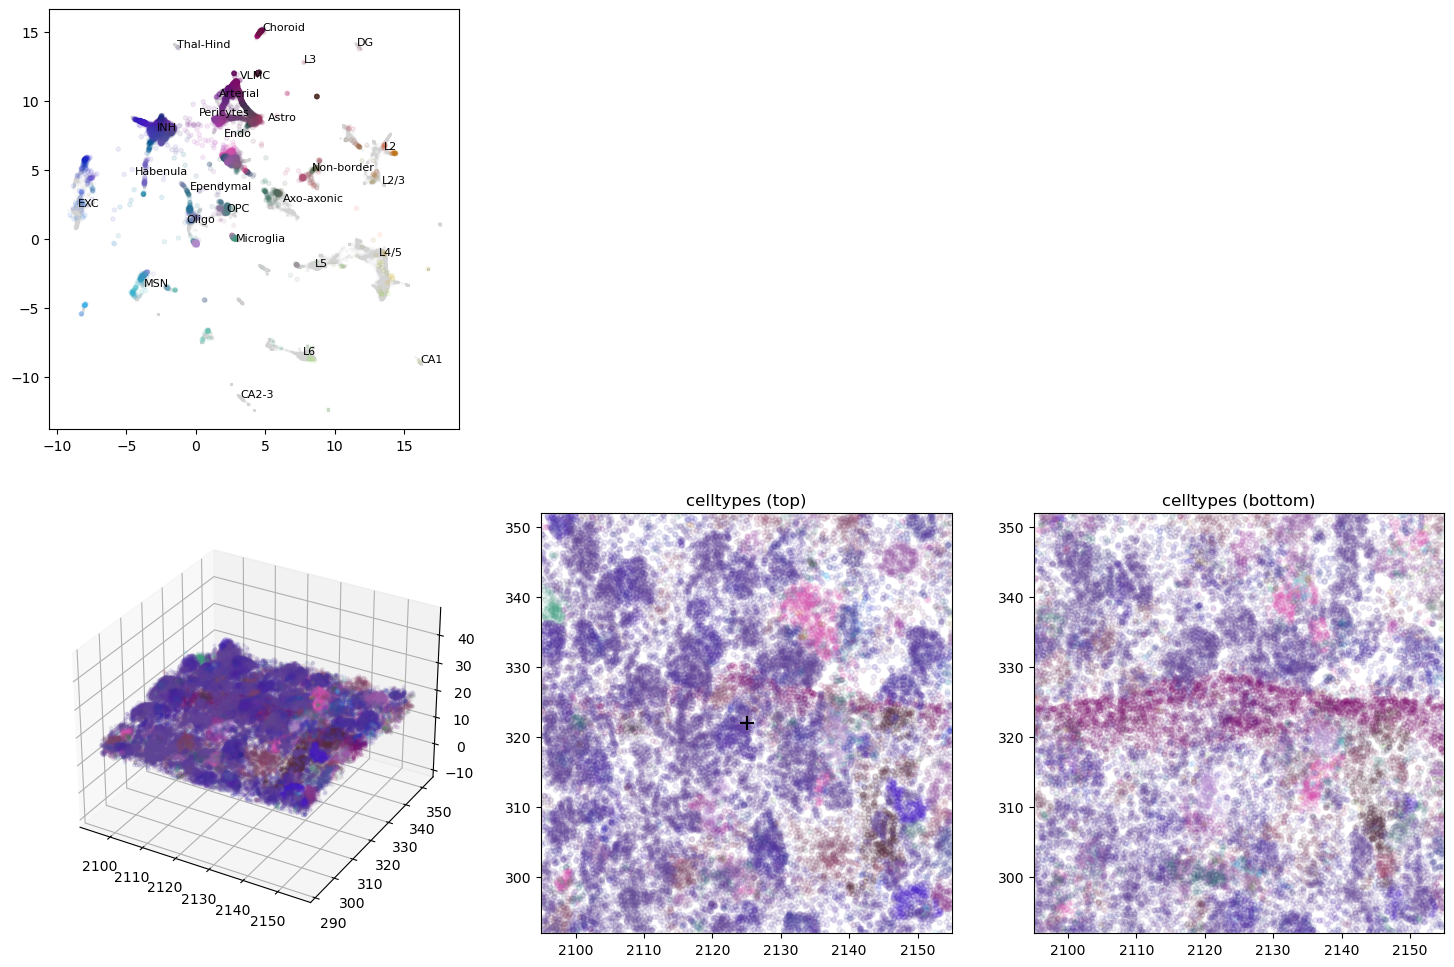

In [64]:
vis.transform(*roi_df[['x','y']].iloc[0].values,spot_df_raw)

#### Load snRNAseq data for cell typing:

In [15]:
# We assign each spot to the nearest celltype, using an annotated single-cell dataset:

# Load the single-cell dataset:
adata_snrna = anndata.read_h5ad('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/adata_multisection_withclusters_only_nuclei_annotation.h5ad')
adata_snrna = adata_snrna[:,adata_snrna.var.index.isin(genes)]
adata_snrna.obs = adata_snrna.obs[['celltype_annotation']]

# Load the single-cell dataset:
# adata_scrna = anndata.read_h5ad('../../data/z-incoherence/counts_WS_blur5_exp0.h5ad')
# adata_scrna = adata_scrna[:,adata_scrna.var.index.isin(genes)]
# adata_scrna.obs = adata_scrna.obs[['celltype']]

# adata_sncrna = anndata.concat([adata_snrna,adata_scrna],axis=0,join='outer')
adata_sncrna = adata_snrna
adata_sncrna.obs['celltype_coarse'] = adata_sncrna.obs.celltype_annotation.apply(lambda x: x.split(' ')[0])

adata_sncrna.obs.index = ('Cell_'+pd.Series(np.arange(adata_sncrna.shape[0])).astype(str)).values

# del adata_snrna,adata_scrna

# define a signature matrix of mean celltype expression profiles:
celltypes = sorted(adata_sncrna.obs.celltype_coarse.unique())
signatures = pd.DataFrame(index=genes,columns=celltypes).drop(['Noise','nan','?'],axis=1)

# fill the signatures with mean expression values:
for celltype in signatures.columns:
    subset = adata_sncrna.X[adata_sncrna.obs.celltype_coarse==celltype,:]
    subset = pd.Series(np.nan_to_num(np.array(subset.mean(0)).squeeze()),
                       index=adata_sncrna.var.index)

    signatures[celltype] = subset[genes].values / (subset.sum()+1)


/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [38]:
# # assert False

# ovrlp.visualize_rois(spot_df_raw,roi_df, signature_matrix=signatures,
#                      celltyping_min_expression=5,
#                      n_cases=range(0,5,1),plot_window_size=15)

''

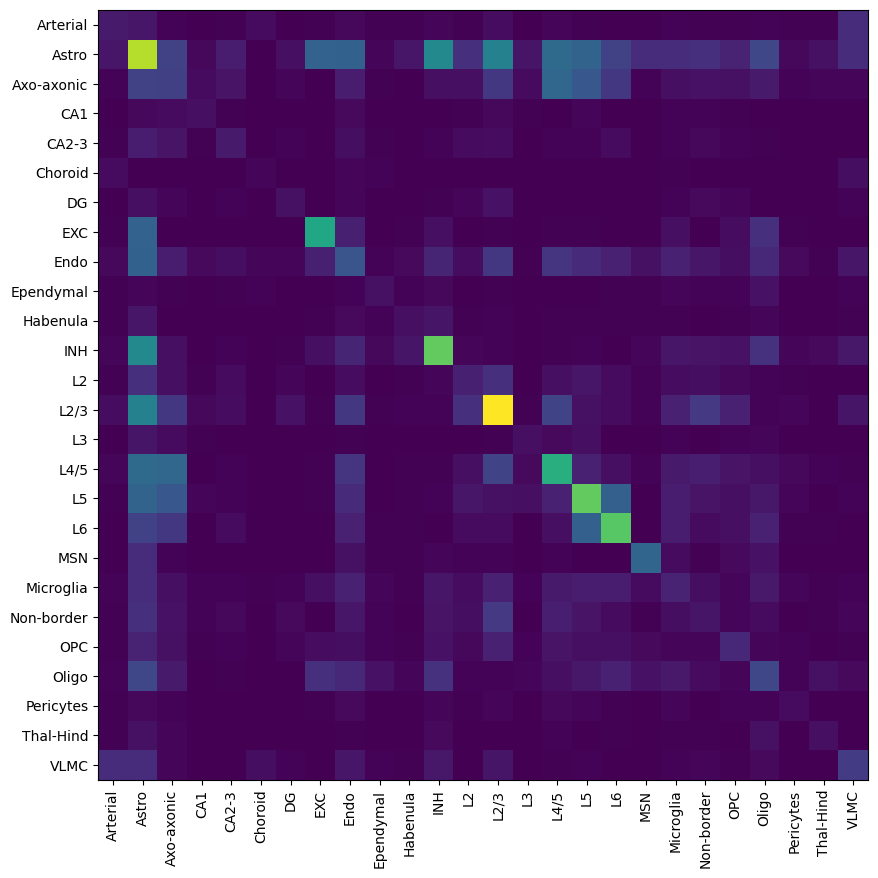

In [39]:
expressions_top = ovrlp.get_expression_vectors_at_rois(df = spot_df_raw[spot_df_raw.z>spot_df_raw.z_delim], rois_x=roi_df.x,
                                        rois_y=roi_df.y,genes=genes)

expressions_bottom = ovrlp.get_expression_vectors_at_rois(df = spot_df_raw[spot_df_raw.z<spot_df_raw.z_delim], rois_x=roi_df.x,
                                        rois_y=roi_df.y,genes=genes)

                                        

celltype_labels_top = ovrlp.determine_celltype_class_assignments(expressions_top,signatures)
celltype_labels_bottom = ovrlp.determine_celltype_class_assignments(expressions_bottom,signatures)

top_bottom_heatmap = np.zeros((len(signatures.columns),len(signatures.columns)))

for i in range(len(celltype_labels_top)):
    top_bottom_heatmap[celltype_labels_top[i],celltype_labels_bottom[i]]+=1#roi_df.divergence[i]
    top_bottom_heatmap[celltype_labels_bottom[i],celltype_labels_top[i]]+=1#roi_df.divergence[i]

plt.figure(figsize=(10,10))
plt.imshow(top_bottom_heatmap)
plt.xticks(range(len(signatures.columns)),signatures.columns,rotation=90)
plt.yticks(range(len(signatures.columns)),signatures.columns)

''

''

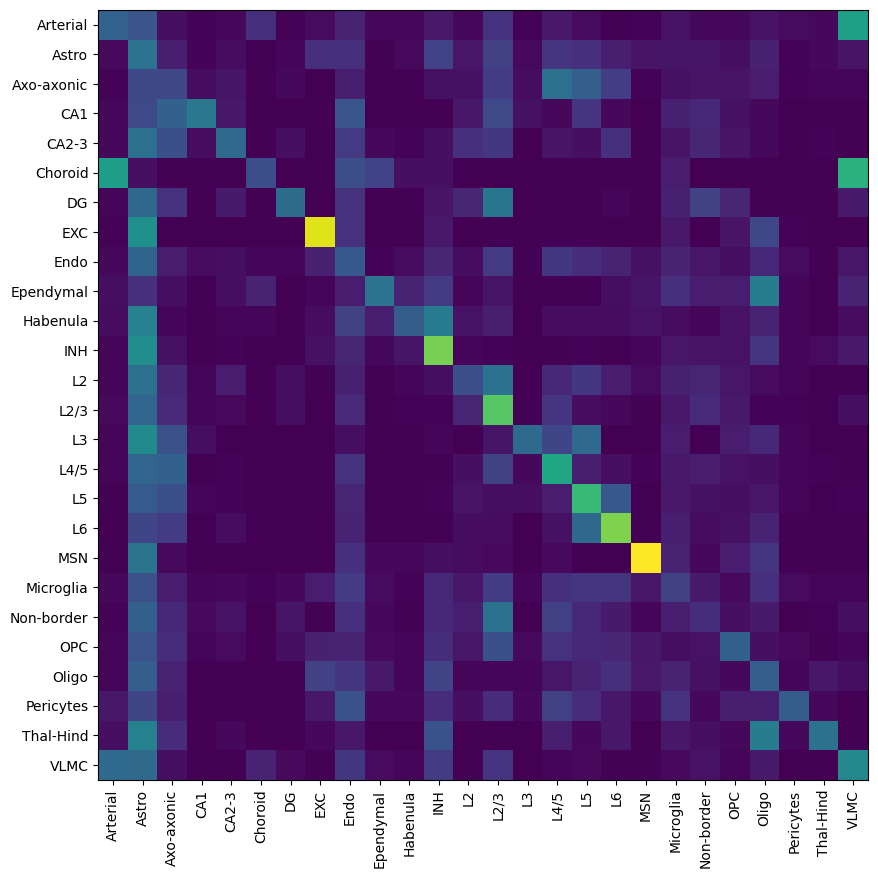

In [43]:
top_bottom_heatmap_normalized = top_bottom_heatmap.copy()/top_bottom_heatmap.sum(1)[:,None]

plt.figure(figsize=(10,10))
plt.imshow(top_bottom_heatmap_normalized)
plt.xticks(range(len(signatures.columns)),signatures.columns,rotation=90)
plt.yticks(range(len(signatures.columns)),signatures.columns)

''

